# **1. Import Libraries**

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import mean_absolute_error
# Set style
sns.set_theme(style="whitegrid")

# **2. Load the Dataset**

In [81]:
df = pd.read_csv('accelerometer.csv')
df.head()

,wconfid,pctid,x,y,z
0,1,20,1.004,0.090,-0.125
1,1,20,1.004,-0.043,-0.125
2,1,20,0.969,0.090,-0.121
3,1,20,0.973,-0.012,-0.137
4,1,20,1.000,-0.016,-0.121


# **3. Check for Missing Values and Dataset Info**

In [82]:
print("\nMissing Values:\n", df.isnull().sum())
print("\nDataset Info:\n")
df.info()


Missing Values:
 wconfid    0
pctid      0
x          0
y          0
z          0
dtype: int64

Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153000 entries, 0 to 152999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   wconfid  153000 non-null  int64  
 1   pctid    153000 non-null  int64  
 2   x        153000 non-null  float64
 3   y        153000 non-null  float64
 4   z        153000 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 5.8 MB


# **4. Visualize the Distribution of Target Classes**

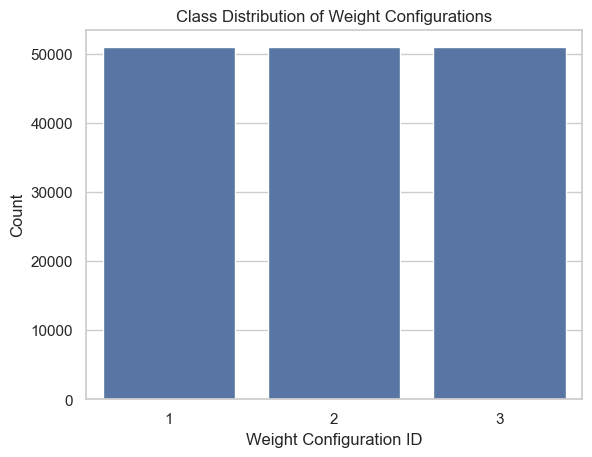

In [83]:
sns.countplot(x='wconfid', data=df)
plt.title('Class Distribution of Weight Configurations')
plt.xlabel('Weight Configuration ID')
plt.ylabel('Count')
plt.show()

# **5. Box Plots of Numerical Features**

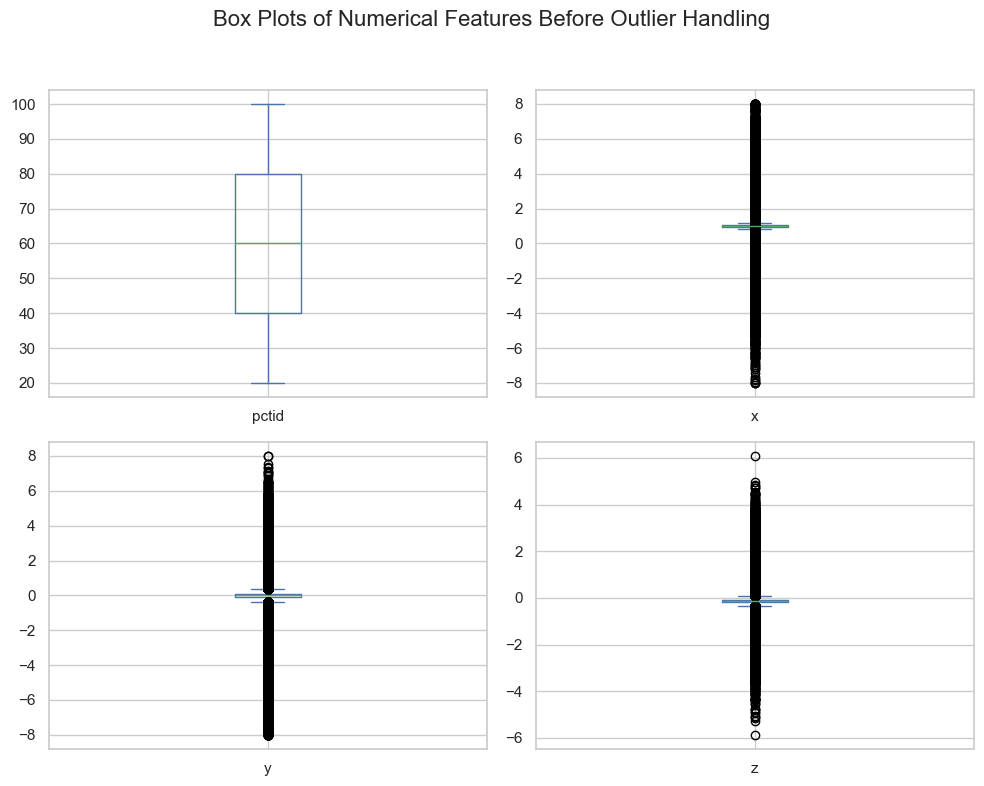

In [84]:
# Visualize Boxplots
df[['pctid', 'x', 'y', 'z']].plot(kind='box', subplots=True, layout=(2, 2), figsize=(10, 8))
plt.suptitle("Box Plots of Numerical Features Before Outlier Handling", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# **6.Outlier Handling (IQR Method)**

x - Lower Bound: 0.804, Upper Bound: 1.18
y - Lower Bound: -0.3525, Upper Bound: 0.37949999999999995
z - Lower Bound: -0.33099999999999996, Upper Bound: 0.09299999999999997
                   x              y              z
count  153000.000000  153000.000000  153000.000000
mean        0.991911       0.016018      -0.121204
std         0.108126       0.195931       0.127824
min         0.804000      -0.352500      -0.331000
25%         0.945000      -0.078000      -0.172000
50%         0.992000       0.008000      -0.125000
75%         1.039000       0.105000      -0.066000
max         1.180000       0.379500       0.093000


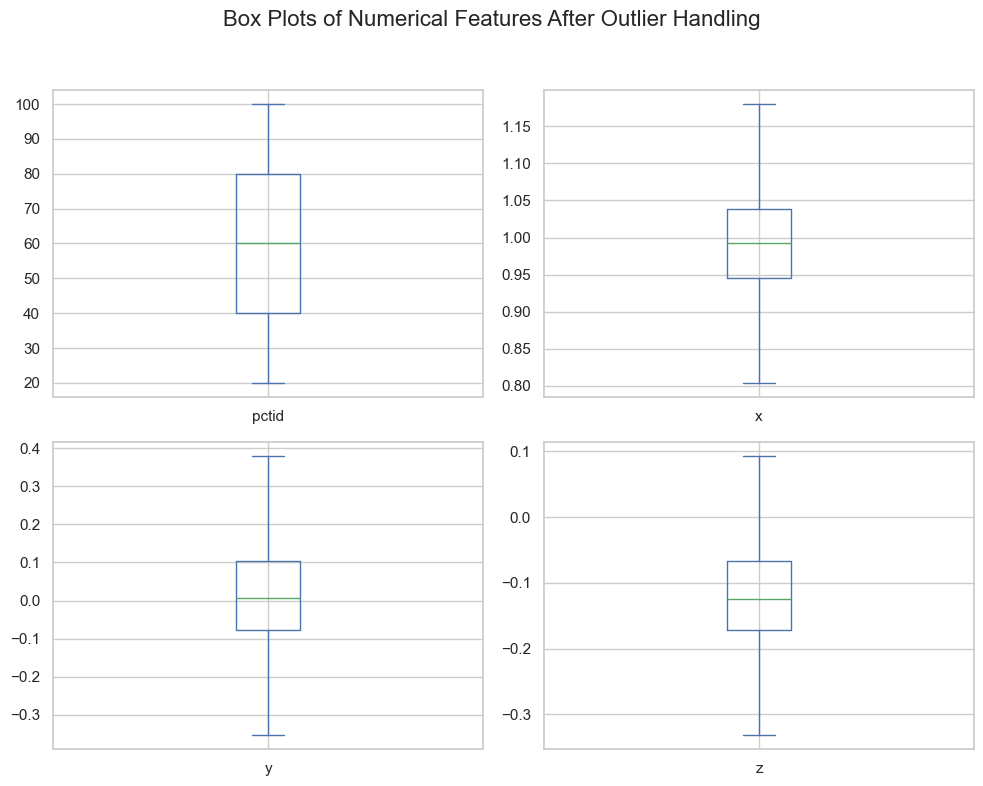

In [85]:
for col in ['x', 'y', 'z']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Print bounds for debugging
    print(f"{col} - Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")

    # Clip outliers
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

# Inspect data after clipping
print(df[['x', 'y', 'z']].describe())

# Visualize Boxplots After Outlier Handling
df[['pctid', 'x', 'y', 'z']].plot(kind='box', subplots=True, layout=(2, 2), figsize=(10, 8))
plt.suptitle("Box Plots of Numerical Features After Outlier Handling", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# **7. Feature Scaling and Train-Test Split**

In [86]:
X = df[['pctid', 'x', 'y', 'z']]
y = df['wconfid']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# **8. Train Random Forest Model**

In [87]:
rf_model = RandomForestClassifier(n_estimators=100, max_features= 1, max_depth=20)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
print("--- RandomForestClassifier Classification Report ---")
print(classification_report(y_test, rf_preds, zero_division=1))

--- RandomForestClassifier Classification Report ---
              precision    recall  f1-score   support

           1       0.63      0.62      0.62     10200
           2       0.62      0.59      0.60     10200
           3       0.83      0.88      0.85     10200

    accuracy                           0.70     30600
   macro avg       0.69      0.70      0.69     30600
weighted avg       0.69      0.70      0.69     30600



# **9. Random Forest Feature Importance**

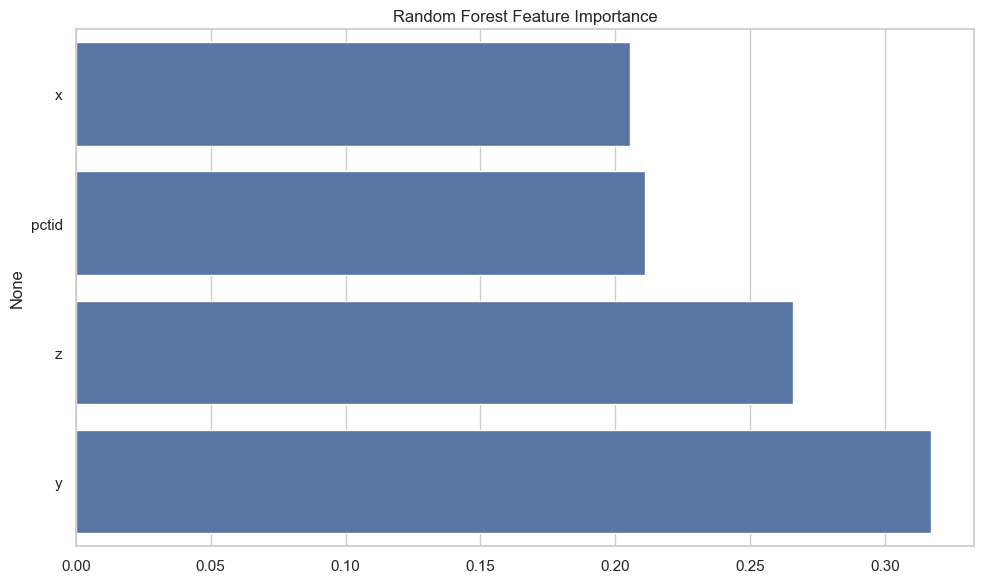

In [88]:
importances = rf_model.feature_importances_
features = X.columns
indices = np.argsort(importances)
plt.figure(figsize=(10, 6))
plt.title("Random Forest Feature Importance")
sns.barplot(x=importances[indices], y=features[indices])
plt.tight_layout()
plt.show()

# **10. Train XGBoost Model**

In [89]:
# Adjust the target variable to start from 0
y = y - y.min()

# Re-split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# Train the XGBoost model again
xgb = XGBClassifier(eval_metric='logloss', max_depth=6, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# Print the classification report
print("\n--- XGBoost Classification Report ---")
print(classification_report(y_test, y_pred_xgb, zero_division=1))

xgb = XGBClassifier(eval_metric='logloss', max_depth=6, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("\n--- XGBoost Classification Report ---")
print(classification_report(y_test, y_pred_xgb, zero_division=1))


--- XGBoost Classification Report ---
              precision    recall  f1-score   support

           0       0.63      0.62      0.63     10200
           1       0.62      0.60      0.61     10200
           2       0.83      0.88      0.85     10200

    accuracy                           0.70     30600
   macro avg       0.69      0.70      0.70     30600
weighted avg       0.69      0.70      0.70     30600


--- XGBoost Classification Report ---
              precision    recall  f1-score   support

           0       0.63      0.62      0.63     10200
           1       0.62      0.60      0.61     10200
           2       0.83      0.88      0.85     10200

    accuracy                           0.70     30600
   macro avg       0.69      0.70      0.70     30600
weighted avg       0.69      0.70      0.70     30600



# **10. Hyperparameter Tuning (Random Forest)**


In [90]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
gs = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, n_jobs=-1, scoring='accuracy')
gs.fit(X_train, y_train)

print("\nBest Parameters from GridSearch:\n", gs.best_params_)


Best Parameters from GridSearch:
 {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}


# **11. Evaluate Best RF Model**

In [91]:
best_rf = gs.best_estimator_
best_rf_preds = best_rf.predict(X_test)

print("\nBest Random Forest Accuracy:", accuracy_score(y_test, best_rf_preds))
print("\nClassification Report (Best RF):\n")
print(classification_report(y_test, best_rf_preds))


Best Random Forest Accuracy: 0.701078431372549

Classification Report (Best RF):

              precision    recall  f1-score   support

           0       0.64      0.62      0.63     10200
           1       0.62      0.61      0.61     10200
           2       0.83      0.87      0.85     10200

    accuracy                           0.70     30600
   macro avg       0.70      0.70      0.70     30600
weighted avg       0.70      0.70      0.70     30600



# **12. Hyperparameter Tuning (XGBoost)**

In [92]:
# **13. Hyperparameter Tuning (XGBoost)**
param_grid_xgb = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3 ,6, 9, 12, 15, 18, 20],
    'learning_rate': [0.01, 0.1, 0.3]
}

grid_xgb = GridSearchCV(
    XGBClassifier(eval_metric='mlogloss', random_state=42),
    param_grid_xgb,
    cv=3,
    n_jobs=-1,
    scoring='accuracy'
)
grid_xgb.fit(X_train, y_train)

print("\\nBest Parameters from XGBoost GridSearch:")
print(grid_xgb.best_params_)


\nBest Parameters from XGBoost GridSearch:
{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 500}


# **13. Evaluate Best XGB Model**

In [93]:
best_xgb = grid_xgb.best_estimator_
best_xgb_preds = best_xgb.predict(X_test)

print("Best XGBoost Accuracy:", accuracy_score(y_test, best_xgb_preds))
print("Classification Report (Best XGBoost):")
print(classification_report(y_test, best_xgb_preds))

Best XGBoost Accuracy: 0.7022549019607843
Classification Report (Best XGBoost):
              precision    recall  f1-score   support

           0       0.64      0.62      0.63     10200
           1       0.63      0.61      0.62     10200
           2       0.83      0.88      0.85     10200

    accuracy                           0.70     30600
   macro avg       0.70      0.70      0.70     30600
weighted avg       0.70      0.70      0.70     30600



# **14. Macro-Averaged F1 Score Comparison**

In [94]:
f1_macro_rf = f1_score(y_test, rf_preds, average='macro')
f1_macro_best_rf = f1_score(y_test, best_rf_preds, average='macro')
f1_macro_xgb = f1_score(y_test, y_pred_xgb, average='macro')
f1_macro_best_xgb = f1_score(y_test, best_xgb_preds, average='macro')

# Print results
print("\nMacro F1 Score - Random Forest:", round(f1_macro_rf, 4))
print("Macro F1 Score - Best Random Forest (Tuned):", round(f1_macro_best_rf, 4))
print("Macro F1 Score - XGBoost:", round(f1_macro_xgb, 4))
print("Macro F1 Score - Best XGBoost (Tuned):", round(f1_macro_best_xgb, 4))


Macro F1 Score - Random Forest: 0.1003
Macro F1 Score - Best Random Forest (Tuned): 0.6992
Macro F1 Score - XGBoost: 0.6957
Macro F1 Score - Best XGBoost (Tuned): 0.7001


# **15. Final Confusion Matrix for Best RF and XGB**

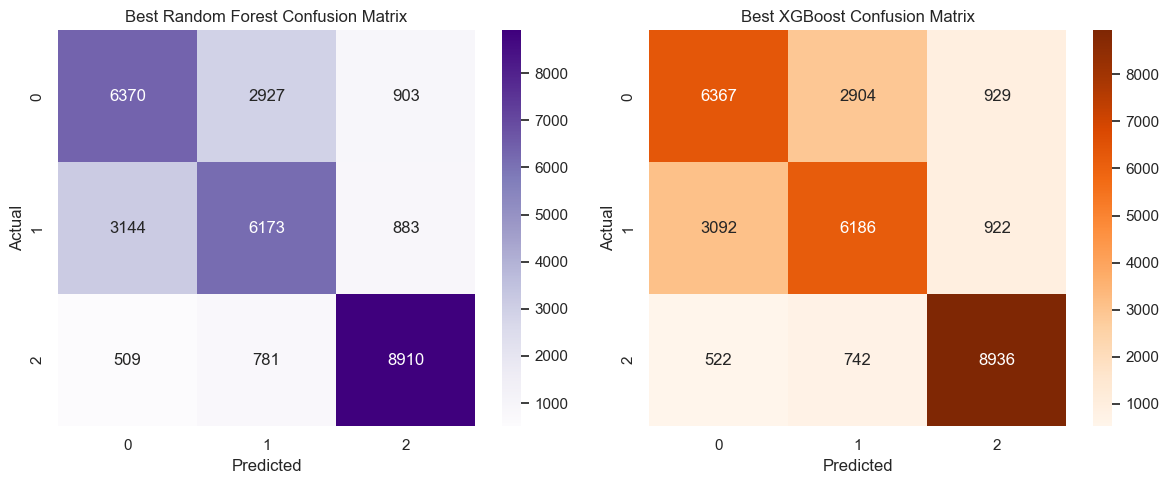

In [95]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Best Random Forest Confusion Matrix
sns.heatmap(confusion_matrix(y_test, best_rf_preds), annot=True, fmt='d', ax=axes[0], cmap='Purples')
axes[0].set_title('Best Random Forest Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Best XGBoost Confusion Matrix
sns.heatmap(confusion_matrix(y_test, best_xgb_preds), annot=True, fmt='d', ax=axes[1], cmap='Oranges')
axes[1].set_title('Best XGBoost Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# **16. Mean Absolute Error Comparison (Random Forest)**


In [96]:
# Calculate MAE
mae_rf = mean_absolute_error(y_test, rf_preds)
mae_best_rf = mean_absolute_error(y_test, best_rf_preds)

# Print the results
print("\nMean Absolute Error - Random Forest (Default):", round(mae_rf, 4))
print("Mean Absolute Error - Best Random Forest (Tuned):", round(mae_best_rf, 4))


Mean Absolute Error - Random Forest (Default): 1.0536
Mean Absolute Error - Best Random Forest (Tuned): 0.3451
